In [1]:
import sys, os, time, shutil, random
from pathlib import Path
_cwd = os.getcwd()
os.chdir(Path(_cwd)/'..')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# %load_ext autoreload
# %autoreload 2
# %pdb
import cv2
import omnifig as fig
import numpy as np
np.set_printoptions(linewidth=120)
import pickle
from tabulate import tabulate
from tqdm.notebook import tqdm
import torch
from torch import nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.multiprocessing as mp
from torch import optim as opt

# import torchvision.models
from torch.utils.data import Dataset, DataLoader, TensorDataset
import networkx as nx

%matplotlib notebook
import matplotlib.pyplot as plt
#plt.switch_backend('Qt5Agg') #('Qt5Agg')
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.cm
from matplotlib import animation
import matplotlib as mpl
# mpl.rc('image', cmap='gray')
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import normalize

fig.initialize()

import omnilearn as learn
from omnilearn import models
from omnilearn import util
from omnilearn.data import InterventionSamplerBase
from omnilearn import viz as viz_util

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import datasets, manifold

# import gpumap
from c3linearize import linearize, class_graph

In [2]:
B = 1000
D = 2
noise = 0.05
device = 'cuda:0'


# def _snap(pts, model=None):
#     plt.figure()
#     plt.scatter(*pts.t(), s=4, marker='o', c='k')
    
#     if model is not None:
#         segs = model.segs
#         anchors = segs.detach().cumsum(0)
#         plt.plot(*anchors.t(), marker='o', c='C1', mfc='w', mec='C1')

#     #     with torch.no_grad():
#     #         prj = model.compute_projections(pts)

#     #     starts = pts
#     #     ends = prj
#     #     deltas = ends - starts
#     #     plt.quiver(*starts.t(), *deltas.t(), angles='xy', scale_units='xy', color='C2', scale=1, lw=0.2, alpha=0.3);
#     #     plt.scatter(*prj.t(), s=4, marker='o', c='C2')

#         if segs.grad is not None:
#             start = anchors
#     #         ends = 
#             deltas = -segs.grad.detach().cpu() * lr
#             plt.quiver(*start.t(), *deltas.t(), angles='xy', scale_units='xy', color='C3', scale=1, lw=0.2, alpha=0.6)
#     plt.axis('equal')

In [3]:
def f1(X, a=0.45, b=0.55,s=2,w1=1,w2=8):
    sigma = b + X.mul(w1).cos().mul(X.mul(w2).cos()).mul(a).mul(X.div(s).pow(2).mul(-1).exp())
    return sigma.mul(torch.randn_like(X))
def f2(X, w=8, n=0.1, a=1.):
    return X.mul(w).sin().mul(a).add(torch.randn_like(X).mul(n))

In [4]:
f = f2

X1lin = torch.linspace(-4,4,1000)
X1 = torch.randn(B)

X2lin = f(X1lin)
X2 = f(X1)
ap = torch.stack([X1,X2],-1)
# ap = torch.stack([X1lin,X2lin],-1)
# plt.figure()
# plt.plot(X1lin, X2lin)

In [5]:
theta = 0.1
theta =  torch.tensor(theta)
theta = torch.rand(1).squeeze()
theta = theta * 2 * np.pi
rot = util.rots_2d(theta).squeeze()
pts = ap @ rot
theta.item() / np.pi * 180

149.5734793510305

<IPython.core.display.Javascript object>


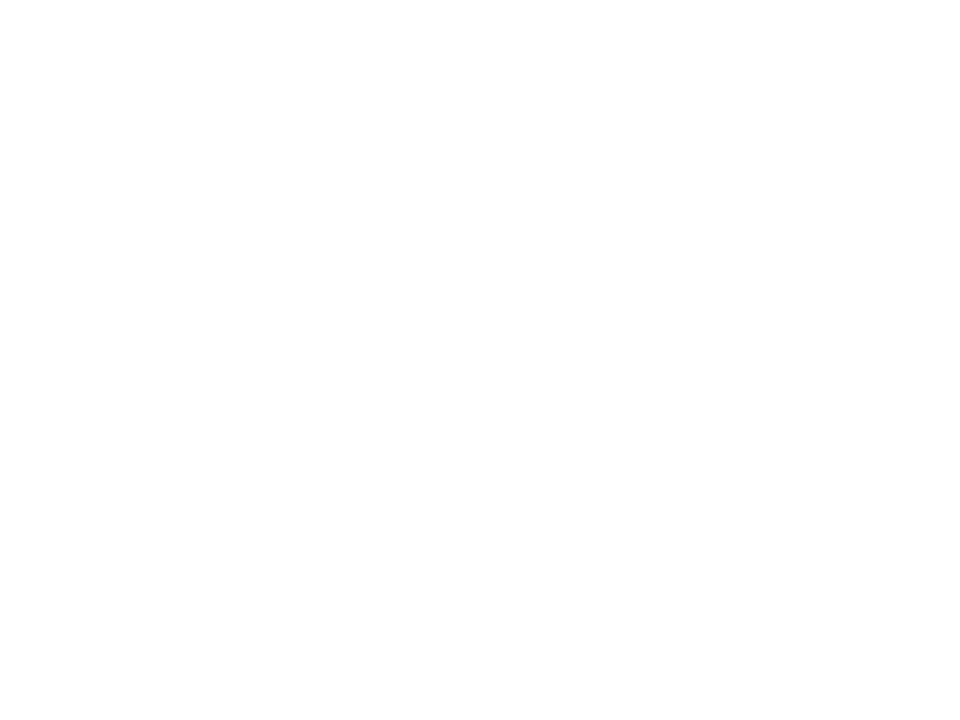

In [6]:
plt.figure()
plt.scatter(*pts.t(), marker='.', c='k', s=1)
plt.axis('equal');

In [13]:
B, D = pts.shape
mu = pts.mean(0,keepdim=True)
P = pts.sub(mu)
U, S, V = torch.svd(P.t() @ P / (B - 1))
S = S.sqrt()
# plt.plot(*torch.stack([torch.zeros_like(U),U.mul(S.unsqueeze(0))],1).add(mu.unsqueeze(0)));
U.shape, S

(torch.Size([2, 2]), tensor([0.9962, 0.7079]))

In [14]:
true_enc = rot[:1].t()
true_dec = rot[:1]
plt.scatter(*(P@true_enc@true_dec).t(), marker='.', c='C1', s=1)

In [15]:
enc = U[:1].t()
dec = U[:1]
enc.shape, dec.shape

(torch.Size([2, 1]), torch.Size([1, 2]))

In [16]:
Q = P @ enc
R = Q @ dec
Q.shape, R.shape

(torch.Size([1000, 1]), torch.Size([1000, 2]))

In [17]:
plt.scatter(*R.t(), marker='.', c='C2', s=1)

In [18]:
starts = torch.linspace(-2,2,1000).view(-1,1)
ends = vecs @ dec @ true_enc
deltas = ends - starts

NameError: name 'vecs' is not defined

In [ ]:
# hidden = [1000]*4

# net = fig.quick_create('mlp', din=1, dout=2, hidden=hidden, nonlin='tanh')
# net

# 3D setting --> N-Helix

In [1336]:
def gen_n_helix(N, num=2):
#     z = torch.randn(N)
    z = torch.rand(N)
    n = torch.randint(num,size=(N,))
    return torch.stack([z,n],-1)
def n_helix(Z, num=2, w=1., amp=None, Rx=1., Ry=2., Rz=1.):
    if amp is None:
        amp = torch.tensor([Rx, Ry, Rz]).float().to(Z.device)
    z = Z.narrow(-1,0,1)
    n = Z.narrow(-1,1,1)
    phi = n.div(num)*2
    theta = z.mul(w).add(phi).mul(np.pi)
    return amp.unsqueeze(0) * torch.cat([theta.cos(), theta.sin(), z],-1)
def cart2cyl(x):
    theta = torch.atan2(x.narrow(-1,1,1),x.narrow(-1,0,1)) / np.pi
    mag = x.narrow(-1,0,2).norm(dim=-1,keepdim=True)
    return torch.cat([mag, theta.cos(), theta.sin(), x.narrow(-1,2,1)],-1)
    return torch.cat([mag, theta, x.narrow(-1,2,1)],-1)
def cyl2cart(x):
    mag = x.narrow(-1,0,1)
    xy = x.narrow(-1,1,2)
    return torch.cat([mag*xy,x.narrow(-1,3,1)],-1)
    theta = x.narrow(-1,1,1) * np.pi
    return torch.cat([theta.cos().mul(mag), theta.sin().mul(mag), x.narrow(-1,2,1)],-1)

In [1337]:
use_cyl = False

In [1338]:
nhelix = 2
Z = gen_n_helix(1024, num=nhelix)
Z.shape

torch.Size([1024, 2])

In [1486]:
X = n_helix(Z, w=4, Rx=1, Ry=1, Rz=4, num=nhelix)

noise_mag = torch.tensor([1,1,1]).unsqueeze(0).float() * 0.05
noise = noise_mag * torch.randn_like(X)
X = X + noise
pts = X.sub(X.mean(0,keepdim=True))
ppts = pts.clone()
if use_cyl:
    pts = cart2cyl(pts)
    rot = torch.eye(pts.shape[-1])
else:
    # rot = util.quat2mat(torch.randn(4))
    rot = torch.eye(3)
    pts = pts @ rot
    ppts = ppts @ rot
pts.shape

torch.Size([1024, 3])

<IPython.core.display.Javascript object>


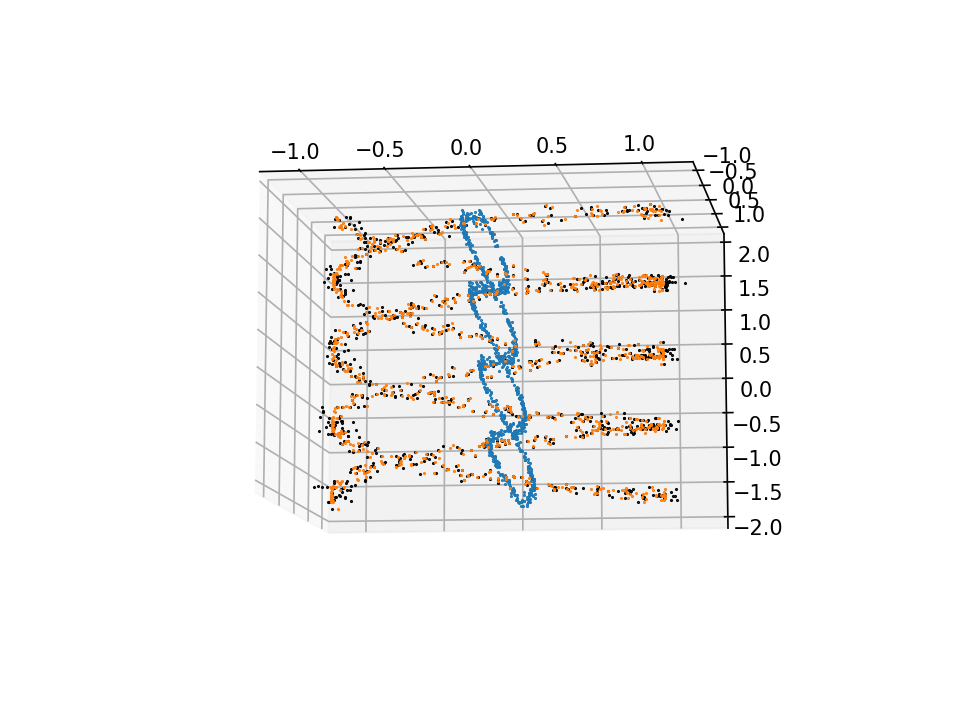

In [1487]:
plt.figure()
data_ax = plt.axes(projection='3d')
plt.plot(*ppts.t(), ls='', marker='.', c='k', ms=1, );

In [1488]:
B, D = pts.shape
U, S, V = torch.svd(pts.t() @ pts / (B - 1))
S = S.sqrt()
# for i, dr in enumerate(torch.stack([torch.zeros_like(U),U.t().mul(S.unsqueeze(-1))],1)):
#     plt.plot(*dr.t(),c=f'C{i}');
U.shape, S

(torch.Size([3, 3]), tensor([1.1568, 0.7243, 0.6961]))

<IPython.core.display.Javascript object>


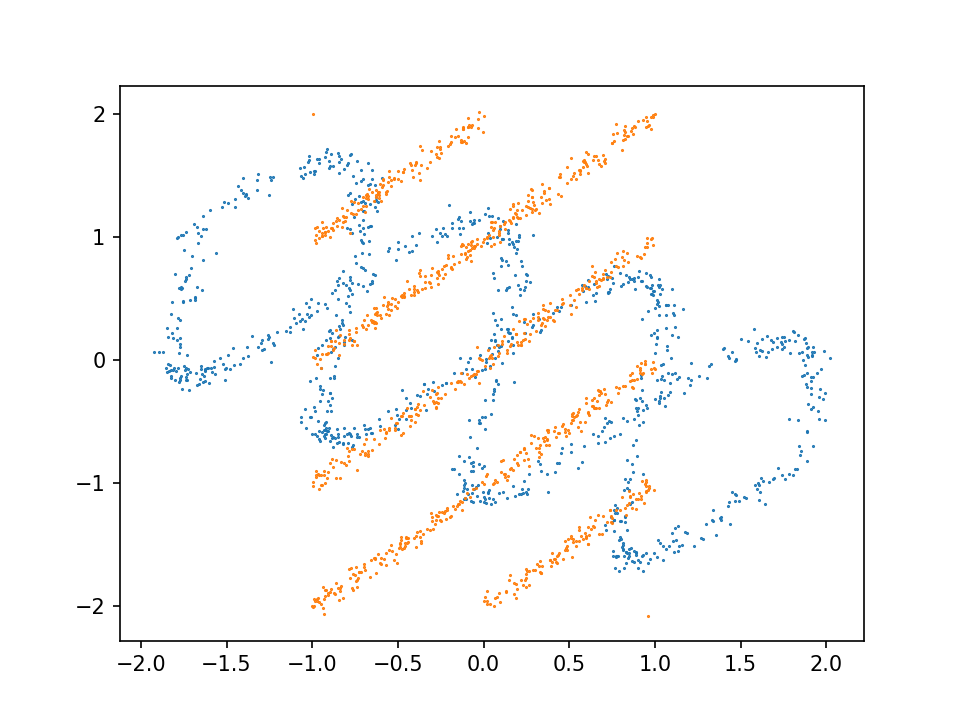

In [1489]:
plt.figure()
q_ax = plt.gca()

In [1490]:
def transform(pts, encode, decode):
    q = encode(pts)
    return q, decode(q)

In [1491]:
def encode_rad(x): 
    x = x @ rot.t()
    if use_cyl:
        theta = torch.atan2(x.narrow(-1,2,1),x.narrow(-1,1,1)) / np.pi
        return torch.cat([theta,x.narrow(-1,3,1)],-1)
        return x.narrow(-1,1,2)
    theta = torch.atan2(x.narrow(-1,1,1),x.narrow(-1,0,1)) / np.pi
    return torch.cat([theta, x.narrow(-1,2,1)],-1)
def decode_rad(q): 
    if use_cyl:
        theta = q.narrow(-1,0,1) * np.pi
        return torch.cat([torch.ones_like(theta), theta.cos(), theta.sin(), q.narrow(-1,1,1)],-1)
        return torch.cat([torch.ones_like(q.narrow(-1,0,1)), q],-1)
    theta = q.narrow(-1,0,1) * np.pi
    q = torch.cat([theta.cos(), theta.sin(), q.narrow(-1,1,1)],-1)
    return q @ rot
    
def encode_lin(x): return x @ U[:2].t()
def decode_lin(q): return q @ U[:2]

In [1492]:
Qlin, Rlin = transform(pts, encode_lin, decode_lin)
Q, R = Qlin, Rlin
color = 'C0'
plt.sca(data_ax)
plt.plot(*R.t(), ls='', marker='.', c=color, ms=1);
plt.sca(q_ax)
plt.plot(*Q.t(),ls='', marker='.', c=color, ms=1);

In [1493]:
Qrad, Rrad = transform(pts, encode_rad, decode_rad)
if use_cyl:
    Rrad = cyl2cart(Rrad)
Q, R = Qrad, Rrad
color = 'C1'
plt.sca(data_ax)
plt.plot(*R.t(), ls='', marker='.', c=color, ms=1);
plt.sca(q_ax)
plt.plot(*Q.t(),ls='', marker='.', c=color, ms=1);

In [1494]:
# starts = torch.linspace(-2,2,1000).view(-1,1)
# ends = vecs @ dec @ true_enc
# deltas = ends - starts

In [1495]:
def get_divergence(deltas):
    divx, divy = np.gradient(deltas, axis=[0,1])
    divM = divx[...,0] + divy[...,1]
    return torch.from_numpy(divM)

In [1496]:
encode, decode = encode_rad, decode_rad

In [1497]:
lr = 0.01
data_dim, latent_dim = pts.shape[-1], 2

In [1531]:
vae_beta = 0.05
# vae_beta = None

hidden = [64]*4
nonlin = 'elu'

encode = fig.quick_create('mlp', din=data_dim, dout=latent_dim*(2 if vae_beta is not None else 1), hidden=hidden, nonlin=nonlin)
decode = fig.quick_create('mlp', din=latent_dim, dout=data_dim, hidden=hidden, nonlin=nonlin)
encode.to(device)
decode.to(device)
optim = opt.Adam(nn.ModuleList([encode,decode]).parameters(), lr=lr,
    betas=(0.9, 0.999),
    eps=1e-08,
#     weight_decay=lr/10,
    amsgrad=True,)
# optim = opt.RMSprop(nn.ModuleList([encode,decode]).parameters(), lr=lr, weight_decay=lr/10, momentum=0.9)
# optim = opt.SGD(nn.ModuleList([encode,decode]).parameters(), lr=lr, momentum=0.9, dampening=0., nesterov=False, weight_decay=lr/10)
criterion = nn.MSELoss(reduction='none')
dataloader = DataLoader(TensorDataset(pts), batch_size=128, shuffle=True)
loader = iter(dataloader)
losses = []

| _din --> din: 3
| _dout --> dout: 4
| hidden_dims --> hidden_fc --> hidden [list with 4 item/s]
|  > (0): 64
|  > (1): 64
|  > (2): 64
|  > (3): 64
| initializer: None (by default)
| nonlin: 'elu'
| output_nonlin --> out_nonlin: None (by default)
| bias: True (by default)
| output_bias --> out_bias: None (by default)
| make_kwargs: {} (by default)
| mode: 'train' (by default)
| device: 'cuda' (by default)
| _din --> din: 2
| _dout --> dout: 3
| hidden_dims --> hidden_fc --> hidden [list with 4 item/s]
|  > (0): 64
|  > (1): 64
|  > (2): 64
|  > (3): 64
| initializer: None (by default)
| nonlin: 'elu'
| output_nonlin --> out_nonlin: None (by default)
| bias: True (by default)
| output_bias --> out_bias: None (by default)
| make_kwargs: {} (by default)
| mode: 'train' (by default)
| device: 'cuda' (by default)


In [1532]:
steps = 4000

In [1533]:
itr = tqdm(range(steps))
if len(losses):
    itr.set_description(f'{losses[-1]:.3f}')
for i in itr:
    try:
        batch = next(loader)[0]
    except StopIteration:
        loader = iter(dataloader)
        batch = next(loader)[0]
    
    batch = batch.to(device)
    q = encode(batch)
    loss = 0.
    if vae_beta is not None:
        mu, logsigma = q.chunk(2, -1)
        sigma = logsigma.exp()
        q = distrib.Normal(mu,sigma).rsample()
        loss += vae_beta * (mu.pow(2) - logsigma + sigma - 1).sum() / 2
    rloss = criterion(decode(q), batch).sum()
    loss += rloss
    optim.zero_grad()
    loss.backward()
    optim.step()
    losses.append(rloss.cpu().item())
    itr.set_description(f'{losses[-1]:.3f}')

  0%|          | 0/10000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


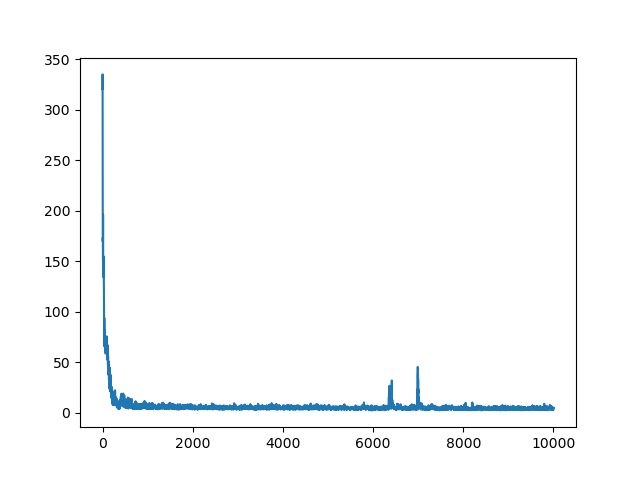

In [1534]:
plt.figure()
plt.plot(losses);

In [1502]:
with torch.no_grad():
    Q = encode(pts.to(device)).cpu()
    if vae_beta is not None:
        Q, Q_lsigma = Q.chunk(2,-1)
    R = decode(Q.to(device)).cpu()
    rec = R
    if use_cyl:
        rec = cyl2cart(rec)
Q.shape, rec.shape

(torch.Size([1024, 2]), torch.Size([1024, 3]))

<IPython.core.display.Javascript object>


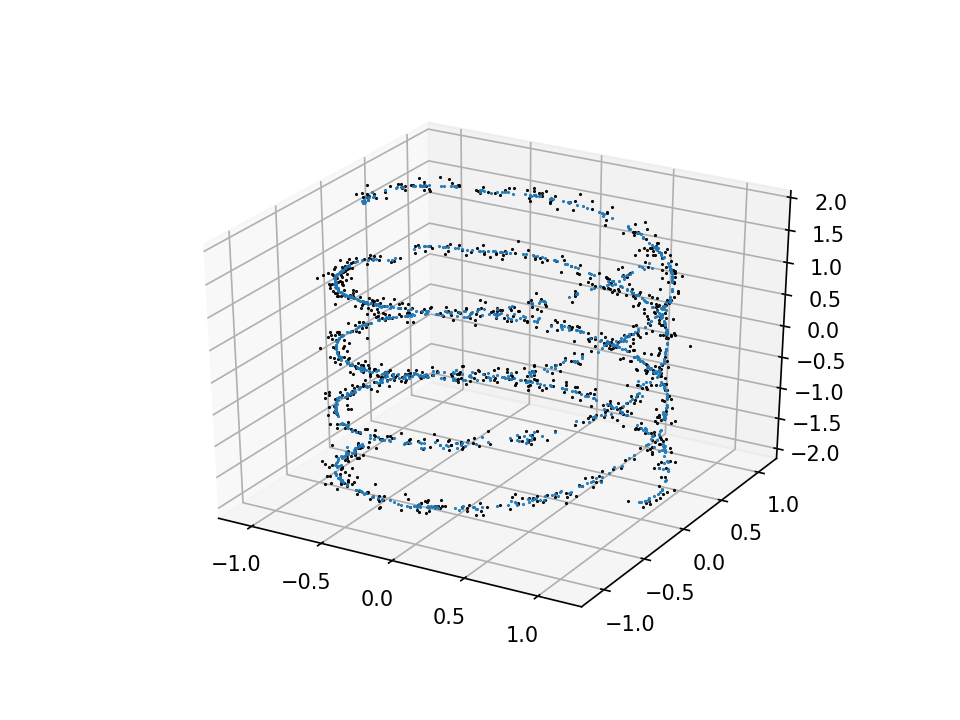

In [1503]:
plt.figure()
data_ax = plt.axes(projection='3d')
plt.plot(*ppts.t(), ls='', marker='.', c='k', ms=1, );
plt.plot(*rec.t(), ls='', marker='.', c='C0', ms=1, );

In [1510]:
rg = 3

mn, mx = Q.min(0)[0], Q.max(0)[0]
mn, mx = torch.ones(2)*-rg, torch.ones(2)*rg
mn, mx

(tensor([-3., -3.]), tensor([3., 3.]))

In [1511]:
n = 150
h, w = n, n

xvals, yvals = torch.linspace(mn[0].item(),mx[0].item(),h), torch.linspace(mn[1].item(),mx[1].item(),w)
# xvals, yvals = torch.linspace(-rg,rg,h), torch.linspace(-rg,rg,w)
cx, cy = torch.meshgrid(xvals, yvals)
cx = cx.reshape(-1)
cy = cy.reshape(-1)

starts = torch.stack([cx,cy],-1)
with torch.no_grad():
    ends = encode(decode(starts.to(device))).cpu()
    if vae_beta is not None:
        ends = ends.chunk(2,-1)[0]
starts = starts.view(h,w,-1)
ends = ends.view(h,w,-1)
deltas = ends - starts
deltas.shape

torch.Size([150, 150, 2])

In [1512]:
magmap = deltas.norm(dim=-1)
divmap = get_divergence(deltas)
sdivmap = divmap.clone()
if sdivmap.min() < 0:
    sdivmap[sdivmap<0] /= sdivmap.min().abs()
else:
    print('WARNING: min')
if sdivmap.max() > 0:
    sdivmap[sdivmap>0] /= sdivmap.max().abs()
else:
    print('WARNING: max')

curvmap = -0.5*get_divergence(deltas.div(magmap.unsqueeze(-1)))
happymap = divmap<0

<IPython.core.display.Javascript object>


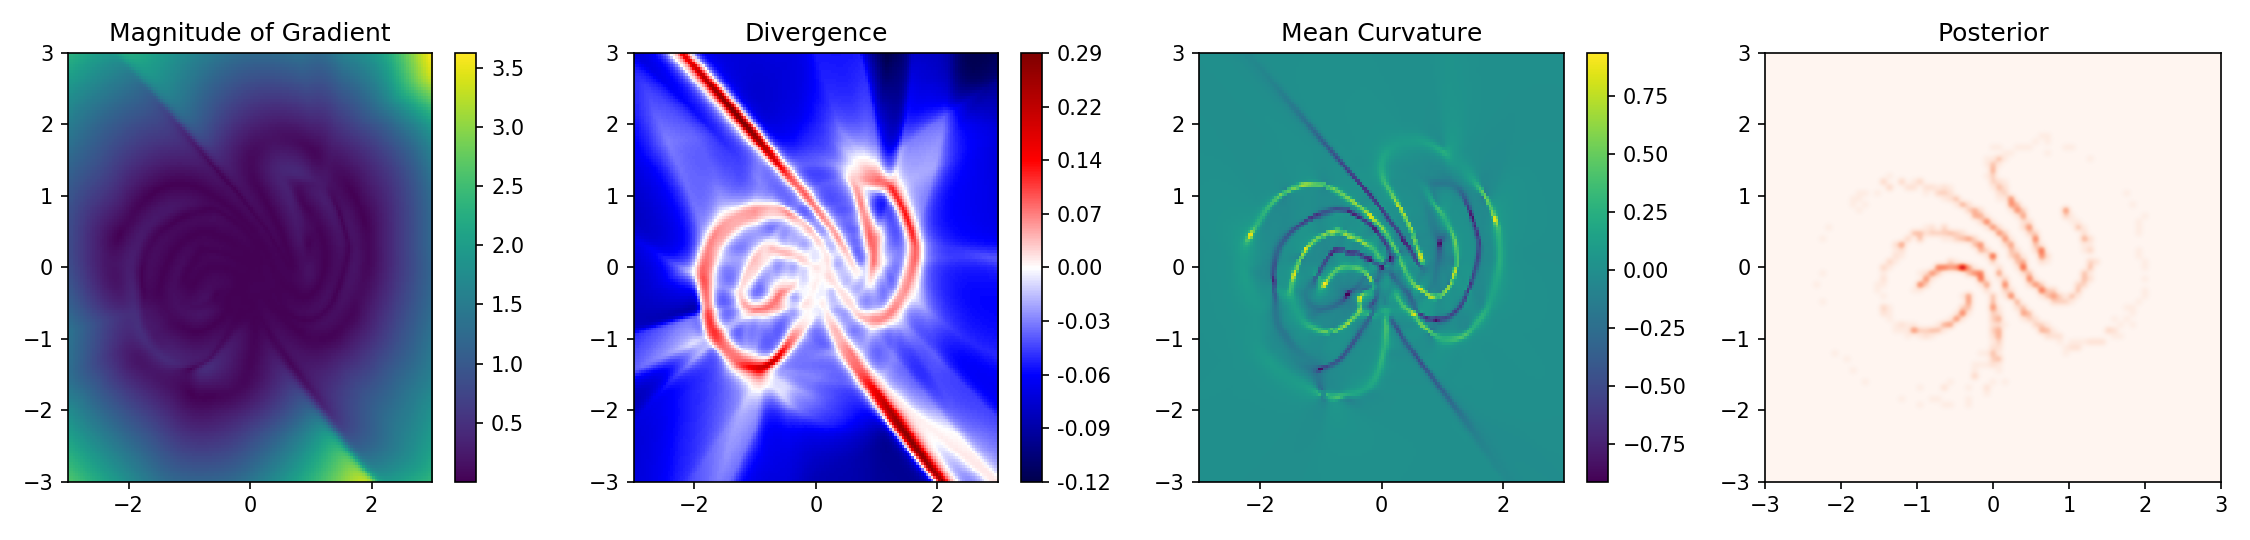

In [1513]:
im_kwargs = dict(
    aspect = 'auto',
    extent=[xvals.min(),xvals.max(),yvals.min(),yvals.max()],
)

fg, axs = plt.subplots(1,4, figsize=(15,3.6))

plt.sca(axs[0])
plt.title('Magnitude of Gradient')
plt.imshow(magmap.numpy().T[::-1], cmap='viridis', **im_kwargs);
plt.colorbar()

plt.sca(axs[1])
plt.title('Divergence')
plt.imshow(sdivmap.numpy().T[::-1], cmap='seismic', **im_kwargs);
cbar = plt.colorbar()
axvals = np.concatenate([np.linspace(divmap.min().item(), 0,5), np.linspace(0,divmap.max().item(),5)[1:]])
axlbls = [f'{v.item():.2f}' for v in axvals]
cbar.set_ticks(np.linspace(-1, 1,9))
cbar.set_ticklabels(axlbls)

plt.sca(axs[2])
plt.title('Mean Curvature')
plt.imshow(curvmap.numpy().T[::-1], cmap='viridis', **im_kwargs);
plt.colorbar()

plt.sca(axs[3])
plt.title('Posterior')
plt.xlim(xvals.min(),xvals.max(),)
plt.ylim(yvals.min(),yvals.max())
hist, *other = np.histogram2d(*Q.t().cpu().numpy(), bins=n//2, normed=True, range=torch.stack([mn,mx]).t().cpu().numpy())
plt.imshow(hist.T[::-1], cmap='Reds', interpolation = "gaussian", **im_kwargs)
# sns.kdeplot(*Q.t().cpu().numpy(), shade=True, ax=axs[3], gridsize=200, thresh=0.01)
badsel = np.ones((*happymap.shape,4))
badsel[...,-1] = 0.
badsel[~happymap.numpy().T[::-1]] = [1,0,0,1]
# plt.imshow(badsel, alpha=0.3, **im_kwargs)
# plt.imshow(mags);
plt.tight_layout()


<IPython.core.display.Javascript object>


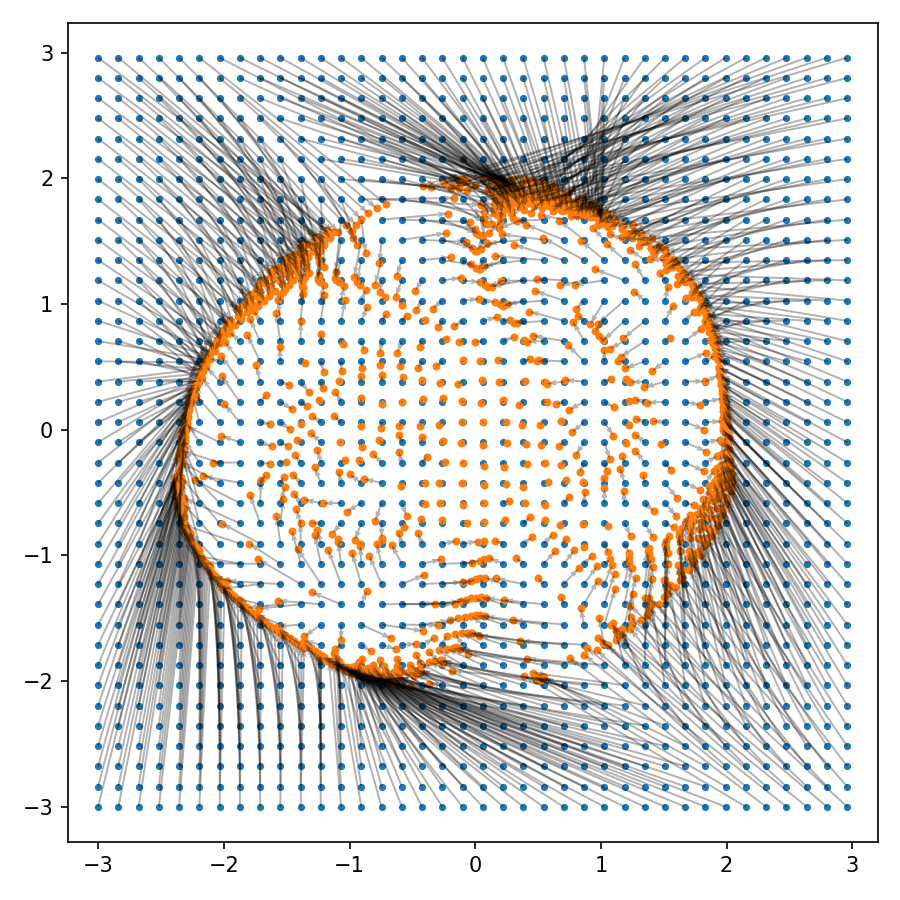

In [1514]:
stepn = 4
s = starts[::stepn,::stepn,].reshape(-1,2)
e = ends[::stepn,::stepn].reshape(-1,2)
d = deltas[::stepn,::stepn].reshape(-1,2)

plt.figure(figsize=(6,6))
plt.scatter(*s.t(), s=6)
plt.scatter(*e.t(), s=8)
plt.quiver(*s.t(), *d.view(-1,2).t(), angles='xy', scale_units='xy', scale=1, lw=0.2, alpha=0.3)
plt.xlim(starts[...,0].min()*1.1, starts[...,0].max()*1.1)
plt.ylim(starts[...,1].min()*1.1, starts[...,1].max()*1.1)
plt.axis('equal')
plt.tight_layout();

<IPython.core.display.Javascript object>


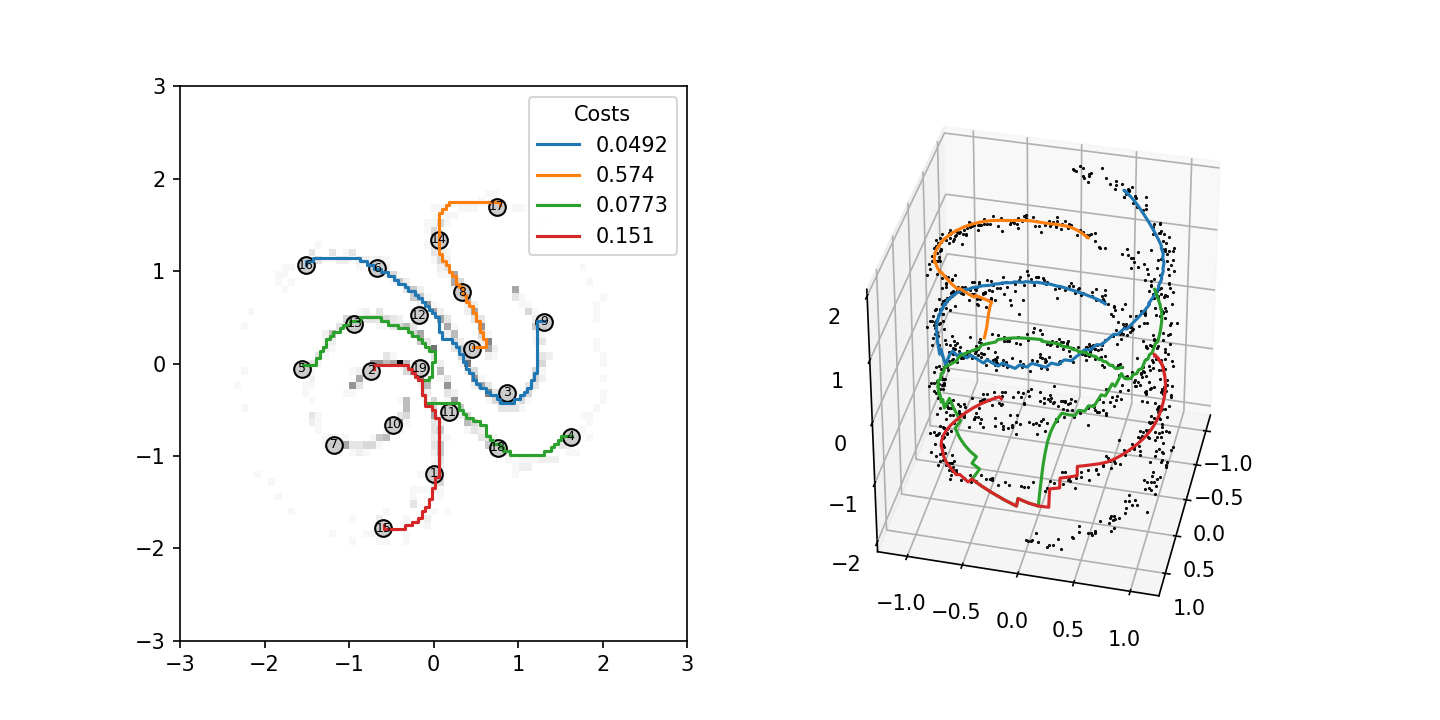

In [1525]:
fg = plt.figure(figsize=plt.figaspect(0.5))
ax_lat_path = fg.add_subplot(1, 2, 1)

plt.imshow(hist.T[::-1], cmap='Greys', **im_kwargs)


ax_data_path = fg.add_subplot(1, 2, 2, projection='3d')

plt.plot(*pts.t(), ls='', marker='.', c='k', ms=1, );
# plt.plot(*R.t(), ls='', marker='.', c='C1', ms=1, );

In [1526]:
# plt.figure()
# ax_lat_path = plt.gca()
plt.sca(ax_lat_path)

# selQ = Q[torch.randperm(len(Q))[:20]]
selQ = torch.from_numpy(KMeans(n_clusters=20, random_state=10).fit(Q.numpy()).cluster_centers_)
xinds = torch.searchsorted(xvals, selQ[:,0].contiguous())
yinds = torch.searchsorted(yvals, selQ[:,1].contiguous())
cinds = torch.stack([xinds,yinds],-1)
cinds = [tuple(c) for c in cinds.tolist()]

for k, q in enumerate(selQ):
    plt.plot(*q, 'o', markerfacecolor='0.8',
             markeredgecolor='k', markersize=8)
    plt.text(*q, str(k), ha='center', va='center', fontsize=6)

    
plt.xlim(xvals.min(),xvals.max(),)
plt.ylim(yvals.min(),yvals.max());
# plt.xlim(sel[...,0].min()*1.1,sel[...,0].max()*1.1,)
# plt.ylim(sel[...,1].min()*1.1,sel[...,1].max()*1.1)

In [1527]:
path_cts = [
    [16,9],
    [17,0],
    [5,4],
    [2,15],
]
all_paths = []
all_costs = []

In [1528]:
landscape = magmap**2
DMAP = nx.grid_2d_graph(*magmap.shape)
# def _cost(u,v,*other):
# #     print(u,v,other)
# #     dr = torch.tensor([v[0]-u[0], v[1]-u[1]]).float().cpu()
# #     return (dr @ deltas[u]).item()
#     return mags[v]
def _find_route(u,v):
    L, ph = nx.algorithms.shortest_paths.weighted.single_source_dijkstra(DMAP, cinds[u], cinds[v], weight=lambda u,v,_o: landscape[v].item())
    return L, (u,v), ph

In [1529]:
for s,e in path_cts:
    cost, _, path = _find_route(s,e)

    xlp, ylp = zip(*path)
    xlp, ylp = xvals[list(xlp)], yvals[list(ylp)]
    Qpath = torch.stack([xlp, ylp],-1)
    all_costs.append(cost)
    all_paths.append(Qpath)
# plt.plot(xlp, ylp, c='m');
# cost, len(path)
all_costs

[0.04924227201627218,
 0.5737492912194284,
 0.07727690798620301,
 0.15127818650651648]

In [1530]:
for i, (path, cost) in enumerate(zip(all_paths, all_costs)):
    with torch.no_grad():
        Xpath = decode(path.to(device)).cpu()
    plt.sca(ax_data_path)
    plt.plot(*Xpath.t(), c=f'C{i}')
    plt.sca(ax_lat_path)
    plt.plot(*path.t(), c=f'C{i}',label=f'{cost:.3g}')
plt.legend(title='Costs');